In [4]:
# Install core dependencies
!pip install langchain langchain_community langchain-openai openai sentence-transformers faiss-cpu pymupdf Pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.4/70.4 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 5.8 MB/s eta 0:00:00


In [24]:
# Replace with your actual OpenAI API key
import os
from google.colab import userdata
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/AdvanceRAG Problems
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY_')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/AdvanceRAG Problems


In [25]:
# PDF processing
import fitz  # PyMuPDF
# Image handling
from PIL import Image
# Embedding models
from sentence_transformers import SentenceTransformer
from transformers import CLIPProcessor, CLIPModel
# Vector DB
import faiss
import numpy as np
# LangChain components
from langchain.schema import Document
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.prompts import ChatPromptTemplate
from langchain.chat_models import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain.retrievers import MultiVectorRetriever
import uuid
import os

In [26]:
pdf_path = "dataPDF/OSI-TCPIP.pdf"
doc = fitz.open(pdf_path)
print(f"Loaded PDF with {len(doc)} pages.")

Loaded PDF with 4 pages.


In [27]:
# Create a folder for extracted images
os.makedirs("MMDRAGimages", exist_ok=True)

pages_data = []

for page_number in range(len(doc)):
    page = doc[page_number]
    text = page.get_text()

    # Extract images on this page
    image_list = []
    for img_index, img in enumerate(page.get_images(full=True)):
        xref = img[0]
        base_image = doc.extract_image(xref)
        image_bytes = base_image["image"]
        image_ext = base_image["ext"]
        image_filename = f"MMDRAGimages/page{page_number+1}_img{img_index+1}.{image_ext}"

        with open(image_filename, "wb") as f:
            f.write(image_bytes)

        image_list.append({
            "image_path": image_filename,
            "caption": f"Image extracted from page {page_number+1}"
        })

    pages_data.append({
        "page_number": page_number + 1,
        "text": text,
        "images": image_list
    })

print(f"Extracted text and images from {len(pages_data)} pages.")

Extracted text and images from 4 pages.


In [28]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)

all_documents = []

for page in pages_data:
    chunks = text_splitter.split_text(page["text"])
    for i, chunk in enumerate(chunks):
        all_documents.append({
            "id": str(uuid.uuid4()),
            "type": "text",
            "content": chunk,
            "page_number": page["page_number"]
        })

print(f"Total text chunks: {len(all_documents)}")

Total text chunks: 10


In [36]:
# Load CLIP model and processor
# Use CLIP text encoder instead of all-MiniLM-L6-v2
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

clip_model.eval()

# Generate text embeddings using CLIP
text_embeddings = []

for doc in all_documents:
    # Truncate the text content to the maximum sequence length for CLIP
    truncated_content = doc["content"][:77]  # Truncate to 77 characters as a proxy for tokens
    inputs = clip_processor(text=[truncated_content], return_tensors="pt", padding=True)
    outputs = clip_model.get_text_features(**inputs)
    embedding = outputs[0].detach().numpy()
    embedding = embedding / np.linalg.norm(embedding)  # normalize

    text_embeddings.append({
        "id": doc["id"],
        "embedding": embedding.tolist(),
        "metadata": doc
    })

print(f"Generated embeddings for {len(text_embeddings)} text chunks.")

Generated embeddings for 10 text chunks.


In [37]:
# Load CLIP model and processor
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

image_embeddings = []

for page in pages_data:
    for image in page["images"]:
        pil_image = Image.open(image["image_path"]).convert("RGB")
        inputs = clip_processor(images=pil_image, return_tensors="pt")
        outputs = clip_model.get_image_features(**inputs)
        embedding = outputs[0].detach().numpy()
        embedding = embedding / np.linalg.norm(embedding)  # normalize

        image_embeddings.append({
            "id": str(uuid.uuid4()),
            "embedding": embedding.tolist(),
            "metadata": {
                "type": "image",
                "image_path": image["image_path"],
                "caption": image["caption"],
                "page_number": page["page_number"]
            }
        })

print(f"Generated embeddings for {len(image_embeddings)} images.")

Generated embeddings for 1 images.


In [38]:
# Combine text and image embeddings
all_vectors = text_embeddings + image_embeddings

dimension = len(all_vectors[0]["embedding"])
index = faiss.IndexFlatIP(dimension)
# Create FAISS index
vectors_np = np.array([vec["embedding"] for vec in all_vectors]).astype('float32')
index.add(vectors_np)

metadata_list = [vec["metadata"] for vec in all_vectors]

print(f"FAISS index built with {index.ntotal} vectors.")

FAISS index built with 11 vectors.


In [54]:
import polars as pl

# Create a list of dictionaries from the combined data
# Each dictionary should contain the metadata and the embedding
vector_db_data = []
for i, vec in enumerate(all_vectors):
    data_row = vec["metadata"].copy() # Start with metadata
    data_row["embedding"] = vec["embedding"] # Add the embedding
    vector_db_data.append(data_row)

# Create a Polars DataFrame
vectordb_df = pl.DataFrame(vector_db_data)

# Display the DataFrame
vectordb_df

id,type,content,page_number,embedding,image_path,caption
str,str,str,i64,list[f64],str,str
"""d28c5b5e-5a27-4fc0-b0bc-670580…","""text""","""Department Of Computer Applica…",1,"[-0.012117, 0.038643, … -0.001548]",null,null
"""1ac1c7ad-6394-43c8-a266-7cd791…","""text""","""Model on any of latest network…",1,"[0.009514, 0.009142, … 0.001736]",null,null
"""5e4061c0-9e2a-4ade-a93b-fb462b…","""text""","""Department of Defense (DoD). O…",1,"[-0.02626, 0.021753, … 0.019422]",null,null
"""3f585725-7b2a-4355-b996-d6d864…","""text""","""Model.  Both have layered a…",1,"[0.013344, 0.025745, … -0.024547]",null,null
"""3c16d77d-f300-4fd8-aeb8-b276c0…","""text""","""Following are some major diffe…",2,"[-0.000843, 0.033872, … -0.013912]",null,null
…,…,…,…,…,…,…
"""f495b1cd-4cdf-46d4-982b-bd4fb5…","""text""","""layer or Session layer. 5. Tr…",2,"[0.000303, 0.019493, … -0.010485]",null,null
"""c7eb0917-bcc5-4020-bd1c-bc7c8a…","""text""","""8. Network layer of OSI model …",3,"[0.007855, 0.043334, … -0.03331]",null,null
"""d3472a5d-ce32-4c69-9353-eb9370…","""text""","""11. OSI model defines services…",3,"[0.027539, 0.045902, … -0.02411]",null,null


In [39]:
from sklearn.metrics.pairwise import cosine_similarity

def multimodal_retriever(query, top_k=5, lambda_mult=0.5):
    # Embed query with CLIP text encoder
    inputs = clip_processor(text=[query], return_tensors="pt", padding=True)
    outputs = clip_model.get_text_features(**inputs)
    query_embedding = outputs[0].detach().numpy()
    query_embedding = query_embedding / np.linalg.norm(query_embedding)

    # Compute cosine similarities
    similarities = cosine_similarity([query_embedding], vectors_np)[0]

    # Get top_k indices
    top_k_idx = similarities.argsort()[-top_k:][::-1]

    results = []
    for idx in top_k_idx:
        results.append({
            "similarity": similarities[idx],
            "metadata": metadata_list[idx]
        })
    return results

In [40]:
# Create ChatPromptTemplate
prompt_template = ChatPromptTemplate.from_template("""
You are a helpful assistant.
Use the context below to answer the question.
Include any referenced images in your response by mentioning the file path.

Context:
{context}

Question:
{question}
""")

llm = ChatOpenAI(model_name="gpt-4o-mini")

output_parser = StrOutputParser()

/tmp/ipython-input-40-3730276542.py:14: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(model_name="gpt-4o-mini")


In [56]:
def answer_query(query):
    retrieved = multimodal_retriever(query, top_k=5)
    # breakpoint()
    context = ""
    for item in retrieved:
        meta = item["metadata"]
        if meta["type"] == "text":
            context += f"[Text] {meta['content']}\n"
        elif meta["type"] == "image":
            context += f"[Image] {meta['caption']} (File: {meta['image_path']})\n"

    prompt = prompt_template.format_messages(
        context=context,
        question=query
    )

    response = llm(prompt)
    answer = output_parser.parse(response)
    return answer, retrieved

In [59]:
import matplotlib.pyplot as plt
question = "Explain Diagrammatic Comparison between OSI Reference Model and TCP/IP."
answer, retrieved = answer_query(question)

print("Assistant Response:\n")
print(answer)

Assistant Response:

content="The diagrammatic comparison between the OSI (Open System Interconnection) Reference Model and the TCP/IP (Transmission Control Protocol/Internet Protocol) Reference Model highlights several key differences between these two networking frameworks.\n\n1. **Structure**:\n   - The OSI model consists of **7 layers**: Application, Presentation, Session, Transport, Network, Data Link, and Physical.\n   - The TCP/IP model has **4 layers**: Application, Transport, Internet, and Network Interface.\n\n2. **Protocol Independence**:\n   - The OSI model is **protocol independent**, serving as a generic standard that acts as a communication gateway between the network and the end user.\n   - The TCP/IP model is **protocol dependent**, built around standard protocols that facilitate communication over the Internet.\n\n3. **Layer Functions**:\n   - The OSI model clearly defines **services, interfaces, and protocols** and makes a clear distinction among them.\n   - In contr


Related Images:


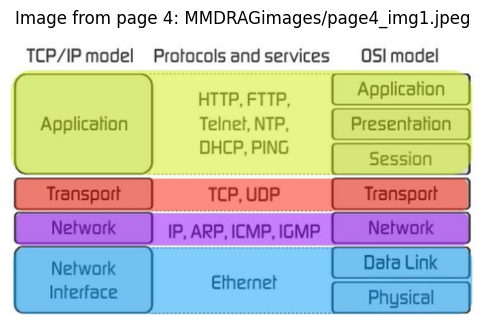

In [60]:
# After your LLM answer
print("\nRelated Images:")

for item in retrieved:
    meta = item["metadata"]

    # If it's an image vector directly, just display it
    if meta["type"] == "image":
        image_path = meta["image_path"]
        img = Image.open(image_path)
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Direct match: {image_path}")
        plt.show()

    # If it's a text chunk, find any image vector on the same page
    elif meta["type"] == "text":
        page_num = meta["page_number"]

        # Search metadata_list for images with the same page
        related_images = [
            m for m in metadata_list
            if m["type"] == "image" and m["page_number"] == page_num
        ]

        for img_meta in related_images:
            image_path = img_meta["image_path"]
            img = Image.open(image_path)
            plt.figure(figsize=(6, 6))
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"Image from page {page_num}: {image_path}")
            plt.show()

In [44]:
retrieved

[{'similarity': np.float32(0.95507985),
  'metadata': {'id': '69819076-669e-4fcd-a2f7-35093ab7b552',
   'type': 'text',
   'content': 'Diagrammatic Comparison between OSI Reference Model and TCP/IP \nReference Model',
   'page_number': 4}},
 {'similarity': np.float32(0.8600875),
  'metadata': {'id': '3c16d77d-f300-4fd8-aeb8-b276c0318071',
   'type': 'text',
   'content': 'Following are some major differences : \nOSI(Open System Interconnection) \nTCP/IP(Transmission Control Protocol / Internet \nProtocol) \n1. OSI is a generic, protocol independent \nstandard, acting as a communication \ngateway between the network and end \nuser. \n1. TCP/IP model is based on standard protocols \naround which the Internet has developed. It is a \ncommunication protocol, which allows connection \nof hosts over a network. \n2. In OSI model the transport layer',
   'page_number': 2}},
 {'similarity': np.float32(0.84408957),
  'metadata': {'id': 'd3472a5d-ce32-4c69-9353-eb93708f6e0f',
   'type': 'text',
 

In [50]:
import matplotlib.pyplot as plt

# Filter retrieved image metadata
retrieved_images = [
    item["metadata"] for item in retrieved if item["metadata"]["type"] == "image"
]

print("\nRelated Images:",retrieved_images)

# Show each image in a grid using Matplotlib
for img_meta in retrieved_images:
    print(img_meta["image_path"])
    img = Image.open(img_meta["image_path"])

    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.title(f"Page: {img_meta['page_number']} - {img_meta['caption']}")
    plt.axis('off')
    plt.show()


Related Images: []


In [22]:
text_metadata_list = [vec["metadata"] for vec in text_embeddings]
image_metadata_list = [vec["metadata"] for vec in image_embeddings]
def multimodal_retriever(query, top_k=5):
    # Embed query for text
    query_text_embedding = text_model.encode(query)
    query_text_embedding = query_text_embedding / np.linalg.norm(query_text_embedding)

    # Embed query for image
    inputs = clip_processor(text=[query], return_tensors="pt")
    query_image_embedding = clip_model.get_text_features(**inputs).detach().numpy()[0]
    query_image_embedding = query_image_embedding / np.linalg.norm(query_image_embedding)

    # Search text index
    _, text_idx = text_index.search(np.array([query_text_embedding]).astype('float32'), top_k)

    # Search image index
    _, image_idx = image_index.search(np.array([query_image_embedding]).astype('float32'), top_k)

    # Combine results
    results = []
    for idx in text_idx[0]:
        results.append({"similarity": None, "metadata": text_metadata_list[idx]})
    for idx in image_idx[0]:
        results.append({"similarity": None, "metadata": image_metadata_list[idx]})

    return results